# Detección de Anomalías

Una **anomalía** es nada más que un punto que presenta desviaciones respecto a lo que es normal, regular o natural. 
En el ámbito de la ciberseguridad, un punto anómalo en nuestro conjunto de datos (logs de usuarios, tráfico de red, emails...) tenderá a representar un **ataque**, ya que indica un comportamiento distinto al que suele haber en nuestros sistemas. Pero, incluso en el caso de que no fuese un ataque o actividad maliciosa, querremos poder detectar conductas aómalas en nuestra organización.

## Exploración de datos

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sns.set_style('white')
%matplotlib inline

### Dataset

Nuestro conjunto de datos son registros de transacciones de tarjetas de crédito de distintos usuarios, y nuestro objetivo será detectar las transacciones fraudulentas.

El dataset contiene datos reales, pero tiene la particularidad de que sus variables fueron generadas PCA (Principal Component Analysis), una técnica de reducción de dimensiones de datos.
Este tipo de métodos se aplican a los datos por varios motivos:

- Anonimización. Esta fue la motivación principal de los creadores del dataset. Aplicando PCA sobre las variables originales se obtienen variables nuevas . El inconveniente principal de usar reducción de dimensionalidad para anonimización es la pérdida de interpretabilidad de las variables, pero podemos seguir usando los datos para clasificación, detección de anomalías, etc, mientras mantengamos intacta la variable que indica la clase/etiqueta de cada dato.

- Solución del "curse of dimensionality". El coste computacional y la dificultad de analizar datos con un montón de variables, a lo que se le llama dimensionalidad alta, es exponencialmente elevado. Muchas veces se aplican técnicas como PCA o TSNE para reducir el número de dimensiones/variables de los datos antes de entrenar algoritmos de ML.

Además, usar nombres de variables abstractos como V1, V2, V3... nos permite reducir nuestro bias hacia los datos, y aumentar la generalización del modelo. Manteniéndonos agnósticos al dominio de aplicación, nos centramos en la selección y procesado objetivo de los datos para obtener los mejores resultados.

In [61]:
df = pd.read_csv('data/creditcard.csv', index_col=0)

In [62]:
df.head(10)

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   
5  0.260314 -0.568671 -0.371407  1.341262  0.359894 -0.358091 -0.137134   
6  0.081213  0.464960 -0.099254 -1.416907 -0.153826 -0.751063  0.167372   
7 -3.807864  0.615375  1.249376 -0.619468  0.291474  1.757964 -1.323865   
8  0.851084 -0.392048 -0.410430 -0.705117 -0.110452 -0.286254  0.074355   
9  0.069539 -0.736727 -0.366846  1.017614  0.836390  1.006844 -0.443523   

        V15       V16       V17       V18  Amount  Class  
0  1.468177 -0.470401  0.207971  0.025791  149.62      0  
1  0.635558  0.463917 -0.114805 -0.183361    2.69      0  
2  2.345865 -2.890083  1.109969 -0.121359  378.66      0  
3 -0.631418 -1.059647 -0.684093  1.965775  123.50      0  
4  0.175121 -0.451449 -0.237033 -0.038195   69.99      0  
5  0.517617  0.401726 -0.058133  0.068653    3.67      0  
6  0.050144 -0.443587  0.002821 -0.611987    4.99      0  
7  0.686133 -0.076127 -1.222127 -0.358222   40.80      0  
8 -0.328783 -0.210077 -0.499768  0.118765   93.20      0  
9  0.150219  0.739453 -0.540980  0.476677    3.68      0

Todas las variables son números decimales, ahorrándonos el problema de tener que lidiar con variables categóricas. La única excepción es 'Class', la etiqueta que distingue transacciones normales de las fraudulentas, que es un valor entero (0 o 1).

In [23]:
df.dtypes

V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
Amount    float64
Class       int64
dtype: object

In [63]:
df.describe()

V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15  9.604066e-16   
std    1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00  1.380247e+00   
min   -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00 -1.137433e+02   
25%   -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01 -6.915971e-01   
50%    1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02 -5.433583e-02   
75%    1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01  6.119264e-01   
max    2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01  3.480167e+01   

                 V6            V7            V8            V9           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15  2.239053e-15   
std    1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00  1.088850e+00   
min   -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01 -2.458826e+01   
25%   -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01 -5.354257e-01   
50%   -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02 -9.291738e-02   
75%    3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01  4.539234e-01   
max    7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01  2.374514e+01   

                V11           V12           V13           V14           V15  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   1.673327e-15 -1.247012e-15  8.190001e-16  1.207294e-15  4.887456e-15   
std    1.020713e+00  9.992014e-01  9.952742e-01  9.585956e-01  9.153160e-01   
min   -4.797473e+00 -1.868371e+01 -5.791881e+00 -1.921433e+01 -4.498945e+00   
25%   -7.624942e-01 -4.055715e-01 -6.485393e-01 -4.255740e-01 -5.828843e-01   
50%   -3.275735e-02  1.400326e-01 -1.356806e-02  5.060132e-02  4.807155e-02   
75%    7.395934e-01  6.182380e-01  6.625050e-01  4.931498e-01  6.488208e-01   
max    1.201891e+01  7.848392e+00  7.126883e+00  1.052677e+01  8.877742e+00   

                V16           V17           V18         Amount          Class  
count  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000  284807.000000  
mean   1.437716e-15 -3.772171e-16  9.564149e-16      88.349619       0.001727  
std    8.762529e-01  8.493371e-01  8.381762e-01     250.120109       0.041527  
min   -1.412985e+01 -2.516280e+01 -9.498746e+00       0.000000       0.000000  
25%   -4.680368e-01 -4.837483e-01 -4.988498e-01       5.600000       0.000000  
50%    6.641332e-02 -6.567575e-02 -3.636312e-03      22.000000       0.000000  
75%    5.232963e-01  3.996750e-01  5.008067e-01      77.165000       0.000000  
max    1.731511e+01  9.253526e+00  5.041069e+00   25691.160000       1.000000

En dataset no nos falta ningún valor, si se diese el caso tendríamos que rellenar el campo (usando, por ejemplo, la media) o eliminar la fila correspondiente.

In [24]:
df.isna().values.any()

False

Tenemos un dataset no balanceado, donde la clase 1 (fraude) tiene muchas menos instancias que la clase 0 (datos normales).

In [44]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Correlación entre variables

Antes de aplicar ningún tipo de AI a nuestros datos, podemos representar su correlación lineal para ver si hay algún tipo de influencia entre sus valores.

En este caso concreto, veremos que las columnas que empiezan por "V" no están relacionadas en absoluto. Esto es un resultado directo de haber sido generadas con PCA, donde queremos poder representar nuestros datos con el mínimo número de dimensiones, por lo que eliminaremos/agruparemos variables que estén relacionadas.

La variable Amount no ha sido modificada, por lo que sí tenemos información sobre ella. Por ejemplo, vemos que tiene una correlación negativa bastante fuerte con V2.

In [55]:
fig = px.imshow(df.corr(),
    labels=dict(color='Correlación'),
    text_auto=True,
    color_continuous_scale='tropic',
    color_continuous_midpoint=0
)
fig.update_layout(
    title_text='Correlación lineal entre variables',
    paper_bgcolor='white',
    height=500, width=800
)

Lo que más nos interesa aquí es ver la correlación entre las variables y la clase (Class). Vemos que no todas influyen de la misma forma, y hay algunas variables que parece que no afectan a la clase en absoluto (de forma lineal).

#### Dispersión a pares de las variables

Aparte de las correlaciones, podemos representar cómo se distribuyen nuestros puntos para cada par de variables (lo llamamos pairplot).

En primer lugar, para reducir el tiempo de cálculo y tener una visualización más clara, creamos un dataframe nuevo con todos los datos anómalas y 3000 muestras de los datos normales.

In [64]:
normal = df[df['Class'] == 0].sample(3000)
anomaly = df[df['Class'] == 1]
sampled_df = normal.append(anomaly, ignore_index=True)
sampled_df['Class'].value_counts()

0    3000
1     492
Name: Class, dtype: int64

Seleccionamos sólo las variables que tengan un nivel de correlación relativamente con la columna Class.

In [45]:
min_correlation = 0.15
high_corr_cols = list(df.corr()['Class'][abs(df.corr()['Class']) > min_correlation].index)
print(f'Variables con correlación > {min_correlation} o < -{min_correlation}: {high_corr_cols}')

Variables con correlación > 0.15 o < -0.15: ['V3', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'Class']


El gráfico representa la distribución de nuestros puntos para ambas clases (Rojo = Normal, Azul Claro = Fraude), para cada par de variables.
En la diagonal tenemos histogramas de cada clase para la misma variable. Nos interesa ver cómo de separables son las dos clases para estos conjuntos de variables.

Podemos apreciar que, dependiendo del conjunto de variables, hay más o menos superposición entre los puntos. Si pudiesemos separar completamente las dos clases para alguna variable o conjunto de variables, tendríamos un problema de clasificación muy sencillo.

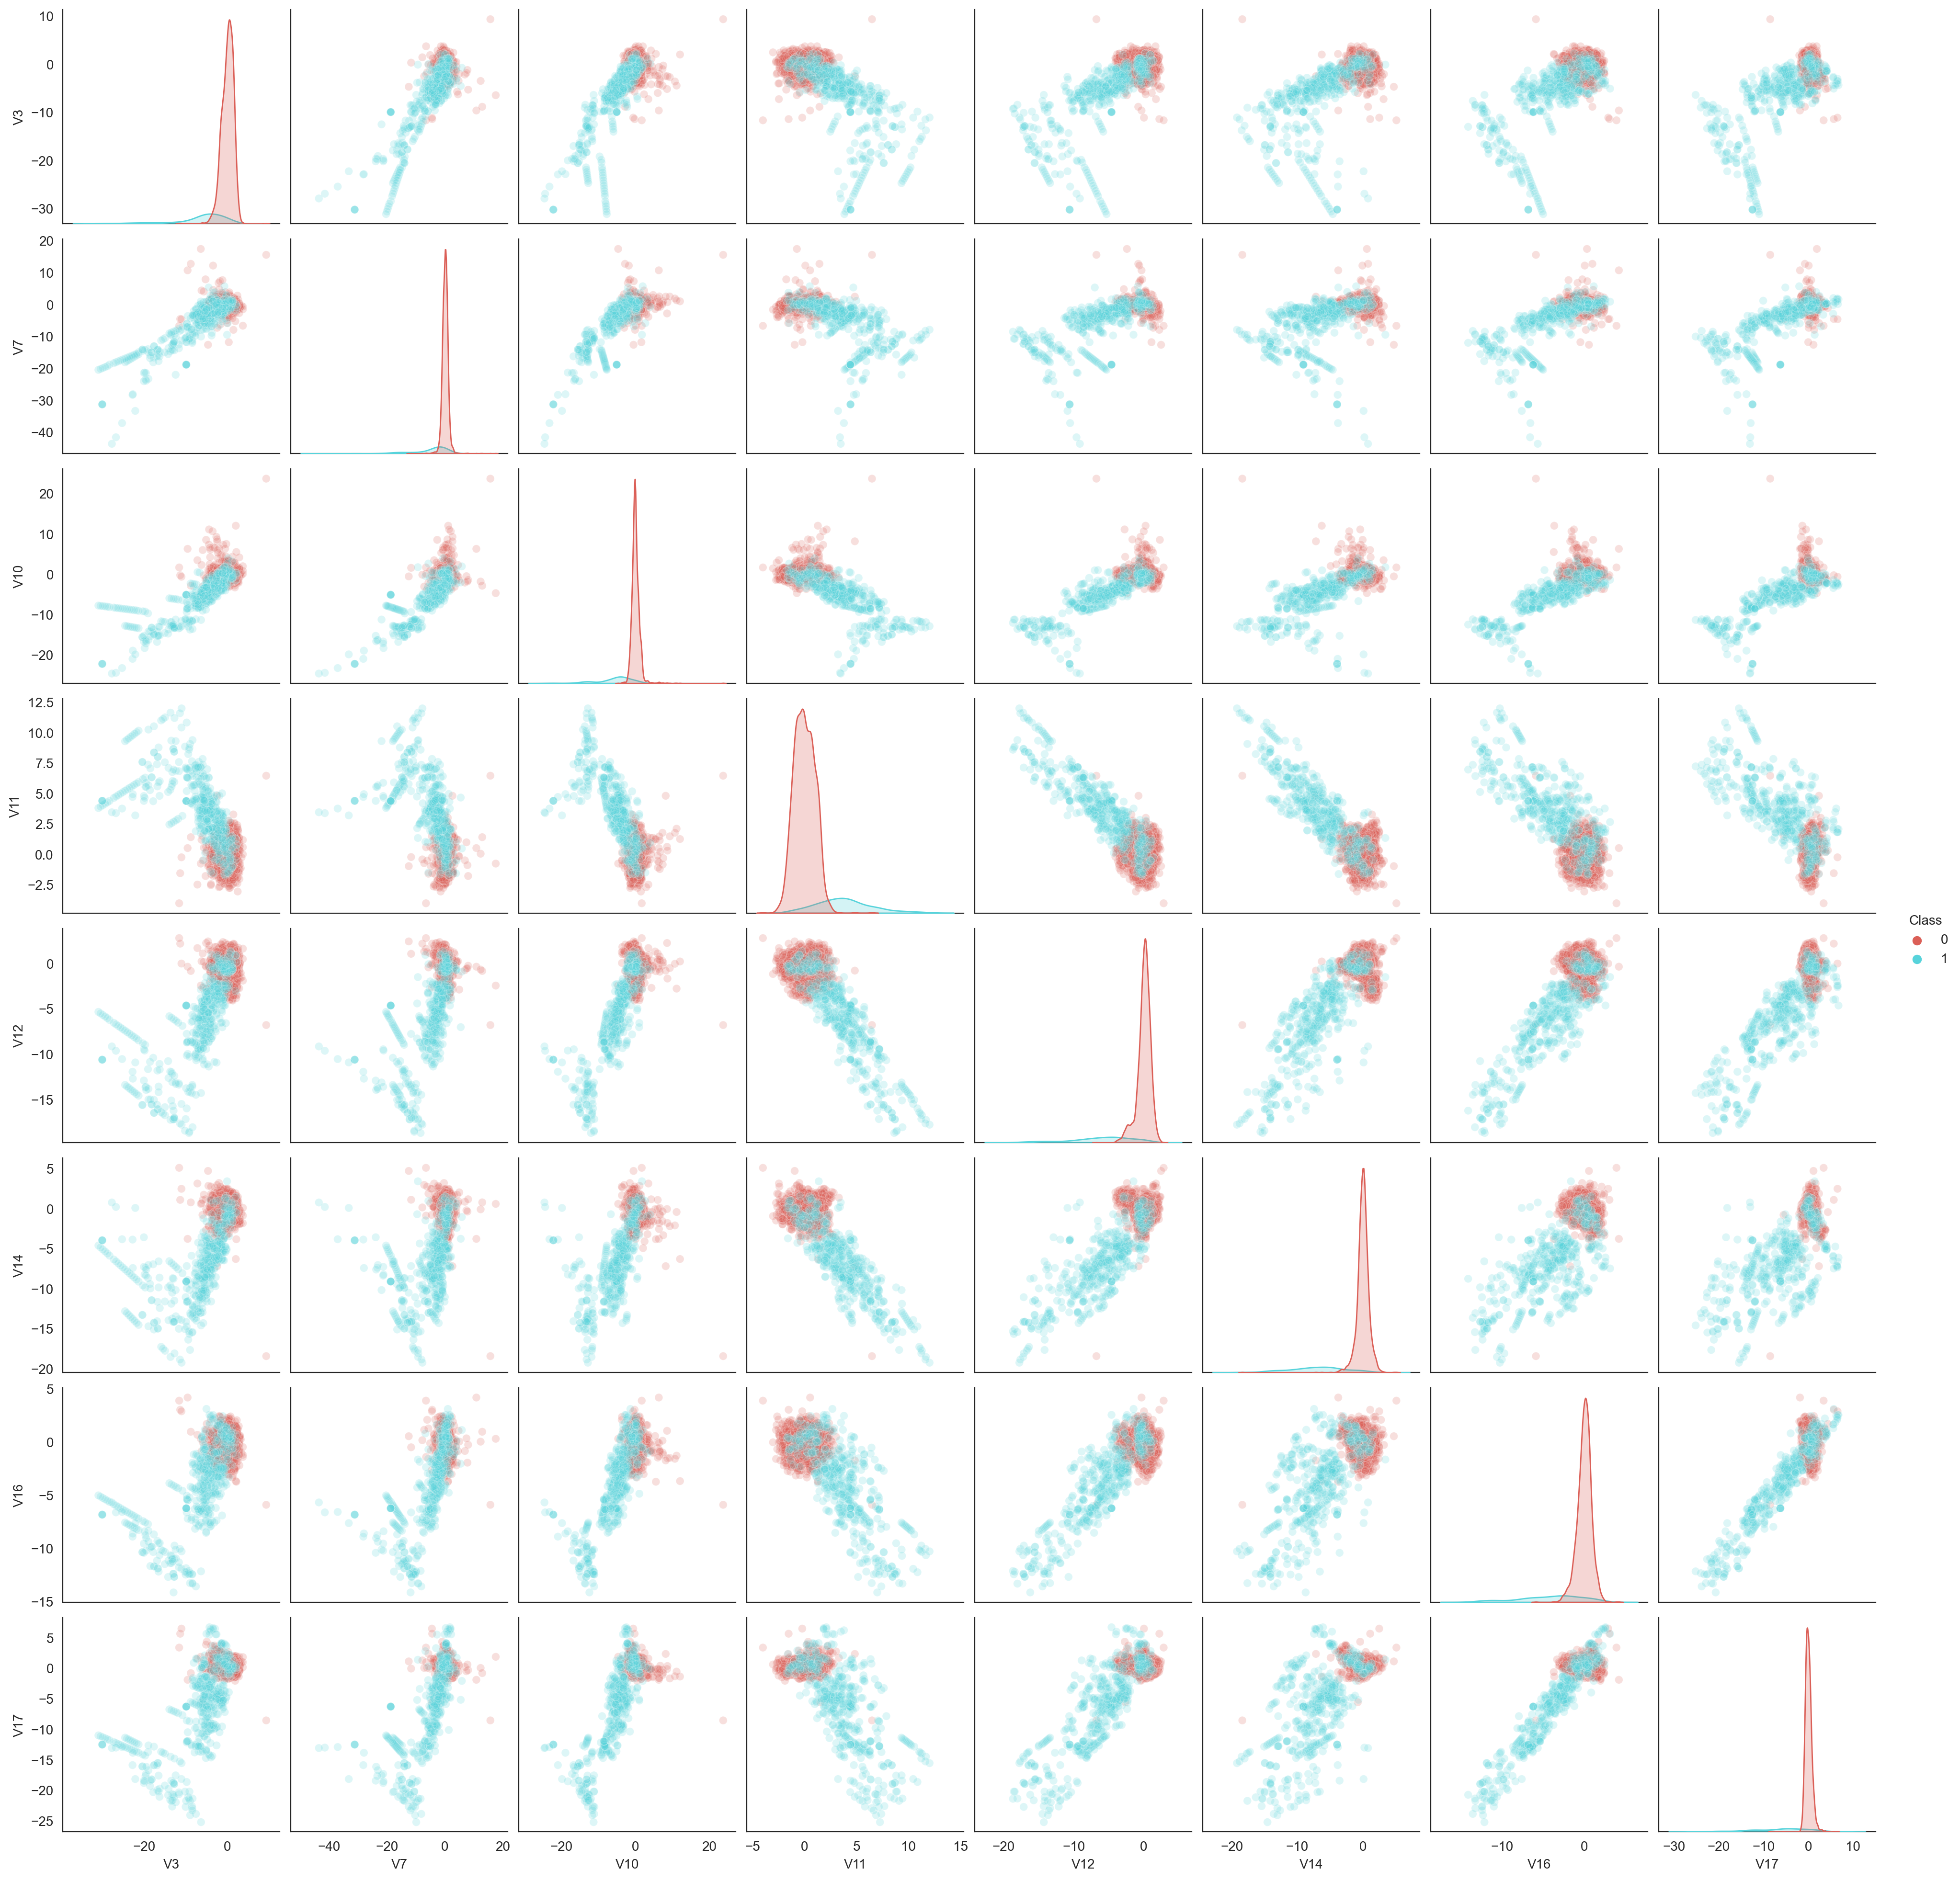

In [46]:
g = sns.pairplot(sampled_df[high_corr_cols], 
             hue="Class", 
             palette='hls',
             plot_kws={"alpha": 0.2})
g.fig.set_dpi(200)

¿Qué pasa si comparamos el gráfico anterior al que obtenemos representando variables con muy poca correlación (< 0.05)?

Escoged algunas variables y representémoslas en un nuevo pairplot:

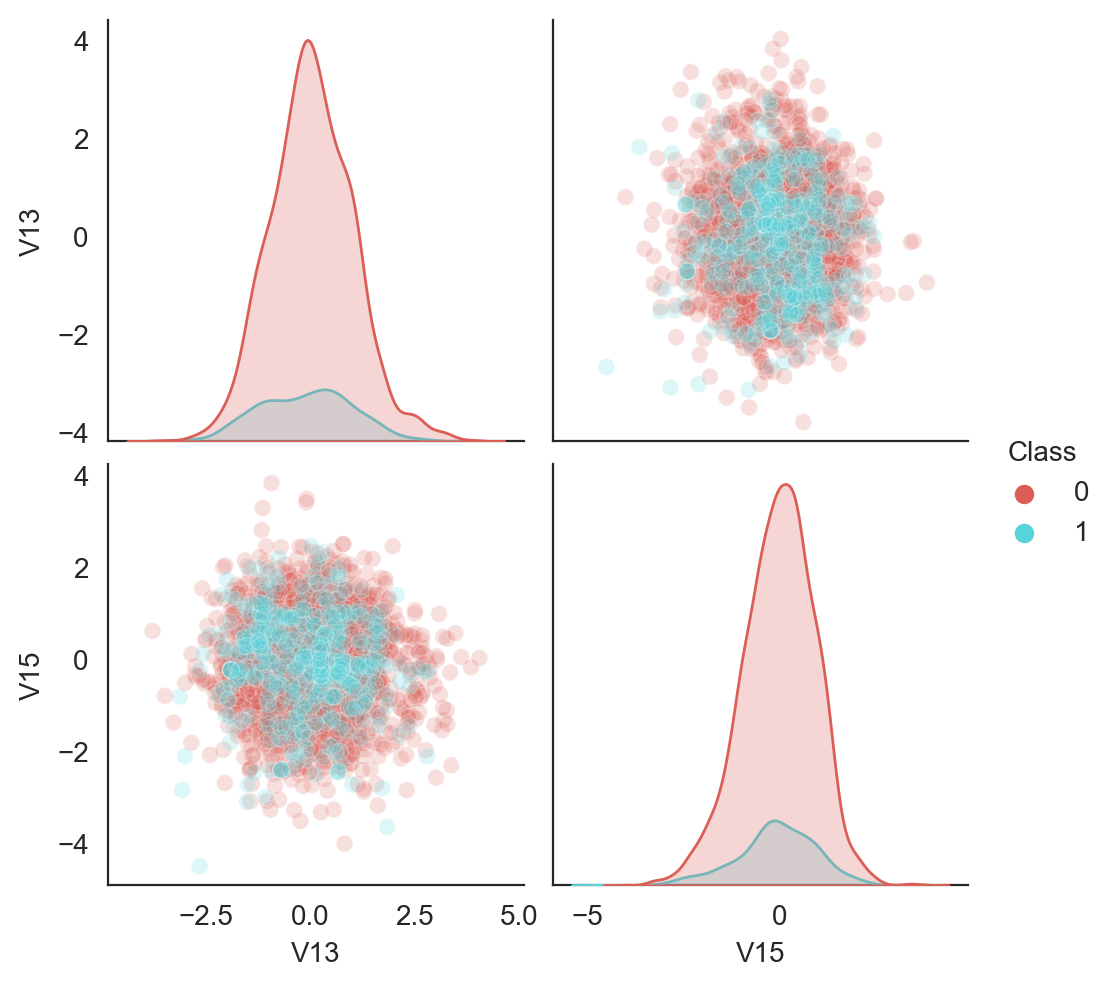

In [49]:
low_corr_cols = [] #escoged columnas!
g = sns.pairplot(sampled_df[low_corr_cols + ['Class']], 
             hue='Class', 
             palette='hls',
             plot_kws={'alpha': 0.2})
g.fig.set_dpi(200)

¿Qué deberíamos observar en estos gráficos?

Tanto los grupos de puntos como los histogramas de estas clases se solapan mucho más que en los gráficos del pairplot de arriba (¡algunas son prácticamente indistinguibles!).
A priori, esto **podría** indicar que estas variables no le aportarán información valiosa al modelo para distinguir entre la clase normal y anómala.

## Detección de anomalías & entrenamiento no supervisado

Vamos a centrarnos en técnicas de entrenamiento **no supervisado** para la detección de anomalías. ¿Qué quiere decir "no supervisado"? Significa que NO necesitamos etiquetas en nuestro conjunto de datos para su entrenamiento. No parece para tanto, pero es una cualidad extremadamente útil para el tipo de situaciones (¡especialmente en ciberseguridad!) donde queremos aplicar detección de anomalías, porque tiene las siguientes implicaciones:

- No tenemos que etiquetar nuestros datos. Normalmente, nosotros no sabemos de antemano cuáles de nuestros correos o logs son maliciosos **antes** de aplicar técnicas de análisis de datos. Es muy dificil etiquetar correctamente este tipo de información, y la mayor parte de organizacione no la tiene disponible. En general, en aplicaciones de ciberseguridad, es muy poco probable que encontremos un dataset etiquetado que se adapte bien y sirva para nuestros objetivos.

- Nuestro modelo de aprendizaje no supervisado va a poder detectar **todo tipo** de comportamientos maliciosos, mientras sean anómalos. Incluso si tuviesemos a mano un dataset perfectamente etiquetado, si utilizamos algorimos supervisados es probable que aprenda a detectar muy bien los ataques que aparecen en el dataset, pero esto no tiene por qué extenderse a otros tipos de ataques que puedan suceder en el futuro.

### Isolation Forest

El Isolation Forest es el modelo de ML que vamos a usar como método de detección de anomalías. Como indica su nombre, es un algoritmo basado en árboles de decisión.
Intenta separar o aislar las instancias anómalas a base de hacer particiones sobre nuestro conjunto de datos. En cada árbol de decisión, va seleccionando valores de división aleatorios para cada variable, y divide los datos en dos grupos dependiendo de si tienen valores mayores o menores que el valor de división. Cada grupo crea una rama nueva en el árbol, donde se realizará la siguiente partición.

Finalmente, la puntuación de anomalía de cada dato se decide en función de la profundidad a la que se encuentra su rama. Los datos anómalos serán más sencillos de separar del resto que los datos normales y necesitarán un número menor de particiones, por tanto se encontrarán en ramas muy poco profundas del árbol. Normalmente el Isolation Forest tiene un umbral de decisión de 0.5, por tanto los datos que obtengan puntuaciones mayores a 0.5 se clasifican como anomalías.

En la imagen podemos ver las particiones de distintos árboles del Isolation Forest, con las anomalías representadas en rojo.

![](images/iforest.webp)


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, RobustScaler

### División de los datos

Para entrenar y evaluar nuestro modelo, primero dividimos el dataset en los datos que usamos para entrenar (X_train) y los datos que usamos para predecir (X_test).

In [185]:
df = df[high_corr_cols]

In [186]:
normal = df[df['Class'] != 1].drop('Class', axis=1)
anomalies = df[df['Class'] == 1].drop('Class', axis=1)

In [187]:
X_train, X_test = train_test_split(normal, random_state=23, test_size=0.1)
y_test = pd.Series([0]*X_test.shape[0])
X_test = X_test.append(anomalies)
y_test = y_test.append(pd.Series([1]*anomalies.shape[0]))
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f'Tamaño de datos de entrenamiento: {len(X_train)}')
print(f'Tamaño de datos de evaluación: {len(X_test)} ({len(anomalies)} anomalías)')

Tamaño de datos de entrenamiento: 255883
Tamaño de datos de evaluación: 28924 (492 anomalías)


### Entrenamiento

#### Parámetros del Isolation Forest

- n_estimators: Número de árboles.
- max_samples: Número de muestras con las que se entrenará cada árbol.
- contamination: Proporcion esperada de anomalías en el conjunto de datos. Sirve para determinar el umbral de decisión.

In [198]:
params = {
    'n_estimators': 200,
    'max_samples': 256,
    'contamination': 'auto',
}

pipeline = Pipeline(
    [   
        #('robust_scaler', RobustScaler()),
        ('norm', MinMaxScaler(feature_range=(0, 1))),
    ]
)

isolation_model = IsolationForest(
    **params,
    warm_start=True,
    verbose=1,
    n_jobs=4,
    random_state=42
)

isolation_model.fit(pipeline.fit_transform(X_train))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


IsolationForest(max_samples=256, n_estimators=200, n_jobs=4, random_state=42,
                verbose=1, warm_start=True)

### Predicción

Tenemos dos funciones importantes:

- score_samples: la función que nos dice la puntuación de anomalía de cada dato

- predict: la función que decide si un dato es anómalo o no. Nuestra implementación del isolation forest devuelve 1 para datos normales y -1 para datos anómalos, así que los cambiamos por 0 y 1 respectivamente para que se adapte a nuestras etiquetas en la columna 'Class'.

Tanto las predicciones (pred) como las puntuaciones (scores) son muy importantes para evaluar correctamente el modelo.

In [205]:
#isolation_model.offset_ = -0.6
scores = isolation_model.score_samples(pipeline.transform(X_test))
X_test['pred'] = isolation_model.predict(pipeline.transform(X_test))
X_test['pred'].replace({1: 0, -1: 1}, inplace=True) 
X_test['scores'] = [-score for score in scores]
X_test['Class'] = y_test

/Users/shenia/miniforge3/envs/gictel/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Class
- pred
- scores
Feature names must be in the same order as they were in fit.




ValueError: X has 11 features, but MinMaxScaler is expecting 8 features as input.

In [206]:
X_test[['scores','pred','Class']].sample(200).head()

scores  pred  Class
9442   0.422729     0      0
1541   0.465893     0      0
8860   0.409466     0      0
18501  0.434656     0      0
27611  0.362905     0      0

### Evaluación

In [201]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
import plotly.express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff

#### Matriz de confusión & métricas derivadas

La matriz de confusión nos permite ver el desempeño de nuestro modelo, representando las instancias en las que acertó y falló para cada clase.

Las filas de la matriz representan la clase real, y las columnas son la predicción de nuestro modelo. Como tenemos sólo dos clases, nuestra matriz tendrá una dimensión de 2x2, de la siguiente forma: 

<img src="images/cm.png" width="600"/>

En la diagonal principal están todas las veces que el modelo acertó en sus predicciones para cada clase (Verdaderos Negativos - TN, y Verdaderos Positivos - VN), aquí es donde queremos que esté la mayor cantidad de instancias posibles.
En la esquina superior derecha tenemos los Falsos Positivos (FP), es decir, las veces que el modelo dijo que algo era una anomalía cuando realmente era un dato normal.
En la esquina inferior izquierda tenemos lo opuesto, las veces que el algoritmo predijo que una transacción era normal, cuando realmente era fraude. Estos son los Falsos Negativos (FN).

Text(0.5, 14.722222222222216, 'Predicción')

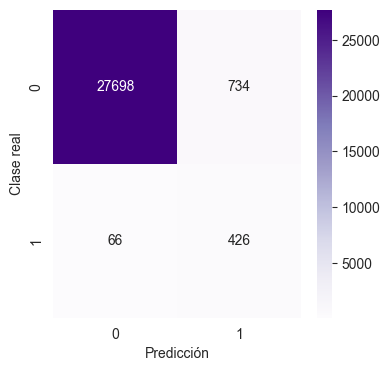

In [202]:
predictions = X_test['pred']
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
fig, ax = plt.subplots(figsize=[4, 4])
sns.heatmap(cm, ax=ax, annot=True, fmt='g', cmap='Purples')
ax.set_ylabel('Clase real')
ax.set_xlabel('Predicción')

A partir de la matriz de confusión podemos sacar varias métricas importantes.

- Accuracy: El porcentaje total de elementos que clasificamos correctamente. Fórmula: (TP + TN) / (TP + TN + FP + FN)

- Precision: Para la clase positiva, permite medir la calidad de las clasificaciones del modelo. Responde a: ¿entre todos los datos que el modelo dice que son anómalos, cuales realmente lo son? Fórmula = TP / (TP + FP)

- Recall: Para la clase positiva, permite medir la cantidad de veces que el modelo acierta. Responde a: ¿entre todos los datos anómalos, cuántos somos capaces de detectar? Fórmula = TP / (TP + FN)

- F1: Media armónica entre precision y recall. Fórmula = (2 * precision * recall) / (precision + recall)

In [203]:
tn, fp, fn, tp = cm.ravel()
metrics = {}
metrics['recall'] = tp / (tp + fn)  
metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
metrics['precision'] = tp / (tp + fp)
metrics['f1'] = 2 * (
    (metrics['precision'] * metrics['recall'])
    / (metrics['precision'] + metrics['recall'])
)
pd.DataFrame.from_records(metrics, index=[1])

accuracy        f1  precision    recall
1  0.972341  0.515738   0.367241  0.865854

#### AUC - Curva ROC

Las métricas que hemos visto hasta evalúan el modelo según sus aciertos, porque nos basamos en las etiquetas de clasificación finales: 0 o 1.

La AUC (Area Under the Curve, o Área Bajo la Curva), en cambio, nos permite ver cómo de bien distingue el modelo entre las dos clases, y si es capaz de separarlas. Para ello, utilizamos las puntuaciones del modelo (en el rango [0,1]) en vez de las predicciones finales.

Si representamos un histograma de las puntaciones que obtiene cada clase, comparadas con el umbral de clasificación de nuestro modelo, obtenemos el siguiente gráfico:

In [204]:
thresh = -isolation_model.offset_
hist_data = [
    X_test['scores'][X_test['Class'] == 0],
    X_test['scores'][X_test['Class'] == 1],
]
colors = ['#835AF1', '#7FA6EE']

fig = ff.create_distplot(
    hist_data,
    ['Normal', 'Anomalía'], 
    bin_size=.015, # cambiar valor para ver con más o menos detalle la distribución de los datos
    histnorm='probability density',
    colors=colors
)
fig.add_vline(
    x=thresh, 
    line=dict(dash='dot'),
    annotation_text=f'  umbral de decisión={thresh:.4f}',
    annotation=dict(font_size=9),
    fillcolor='green'
)

fig.update_layout(height=500, width=800, title_text='Distribución de scores')
fig.update_xaxes(title_text='Score')
fig.show()

Si comparamos este histograma con los que habíamos obtenido al principio para las variables originales del dataset, podemos ver claras diferencias. Como mínimo, ahora no hay solape entre las partes más densas de cada curva. Podemos trazar una linea que divide ambas clases.

Esencialmente, lo que consigue nuestro modelo de detección de anomalías es elaborar una función que cree una variable nueva a partir de nuestro conjunto de datos, la score, que separa lo mejor posible los valores normales de las anomalías.
Si nuestro modelo fuese perfecto, las curvas estarían perfectamente separadas por el umbral de decisión. 

**Nota: este tipo de gráfico normaliza las curvas para que tengan dimensiones similares y se visualicen mejor sus tendencias. En realidad, tenemos muchas menos anomalías que datos normales, lo cual resultaría en un histograma con valores más pequeños.

La AUC ROC es la forma típica de cuantificar esta capacidad del modelo de separar correctamente las dos clases. El AUC es el valor del área bajo la curva ROC, que es una curva de **probabilidad**. 
Para obtenerla, vamos desplazando nuestro umbral de decisión (threshold), y observamos cómo evolucionan nuestra TPR (Tasa de Verdaderos Positivos) y FPR (Tasa de Falsos Positivos). Para obtener una AUC ideal, nuestra curva ROC pasaría por el punto [0,1], lo cual querría decir que existe un umbral de decisión que nos permite tener un 0% de falsos positivos a la vez que un 100% de verdaderos positivos.

El mejor valor posible de AUC es 1, pero el peor valor no es 0 sino 0.5, porque quiere decir que el modelo tiene una probabilidad de 0.5 de acertar, la misma que si escojemos las clases al azar. Si la AUC da 0 es que el modelo está etiquetando las clases al revés (¡pero esto sigue queriendo decir que puede distinguir entre ellas!).

In [195]:
labels=y_test
scores=X_test['scores']

fpr, tpr, _ = roc_curve(labels, scores)
thr = sum(labels) / len(labels)

fig = px.area(
    x=fpr, 
    y=tpr,
    labels=dict(x='FPR',y='TPR'),
    title=f'Curva ROC (AUC={auc(fpr, tpr):.4f})',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.add_trace(
    go.Scatter(
    x=[0,1], y=[0,1], 
    line=dict(dash='dot', color='purple'), 
    name='AUC-ROC base = 0.5')
)

fig.update_layout(height=400, width=600)
fig.show()

Nuestra AUC nos indica que el modelo tiene una capacidad muy alta para separar entre ambas clases, incluso aunque no acierte siempre.

In [196]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.005)
X, y = smote.fit_resample(df.drop('Class', axis=1), df['Class'])
X['Class'] = y

In [197]:
fig = px.imshow(X.corr(),
    labels=dict(color='Correlación'),
    text_auto=True,
    color_continuous_scale='tropic',
    color_continuous_midpoint=0
)
fig.update_layout(
    title_text='Correlación lineal entre variables',
    paper_bgcolor='white'
)